In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ephem 
from simons_array_python.calibration.planet import ephem_planet
from simons_array_python import sa_ephem as sa_ephem
import toast.qarray as qa
from simons_array_python import sa_sql
from toast.tod.sim_focalplane import cartesian_to_quat

INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20211207_benchmark_dataset/pb2a_runid.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20211207_benchmark_dataset/pb2a_runid_g3.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20211207_benchmark_dataset/pb2a_data_quality.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20211207_benchmark_dataset/pb2a_mapping.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20211207_benchmark_dataset/pb2a_monitor.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20211207_benchmark_dataset/pb2a_stim_template.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20211207_benchmark_dataset/pb2a_stim_iq.db attached.


In [2]:
#Convert Az/El to RA/dec using ephem
def azel_to_radecpa(mjd, az, el):
        observer = sa_ephem.pb2a_site()
        ra, dec, pa = [], [], []
        for t, a, e in zip(mjd, az, el):
            observer.date = sa_ephem.mjd_to_ephem_date(t)
            r, d = observer.radec_of(a, e)
            obj = ephem.FixedBody()
            obj._ra, obj._dec = r, d
            obj.compute(observer)
            ra.append(r)
            dec.append(np.pi/2-d)
            pa.append(-obj.parallactic_angle())
        return np.array(ra), np.array(dec), np.array(pa)

In [3]:
def plot_results(det=None, det_offset_x=None, det_offset_y=None):
    #Calculate det pntg with quats
    if det is not None:
        det_offset_x = sa_sql.db_impl.focalplane_db[det].det_offset_x
        det_offset_y = sa_sql.db_impl.focalplane_db[det].det_offset_y
    
    print(
        'Detector offsets x/y in degrees:',
        det_offset_x, 
        det_offset_y)
        
    det_offset_quat = cartesian_to_quat([[det_offset_x, det_offset_y, 0]])[0]
    det_pntg = qa.mult(det_offset_quat, boresight_quat)
    theta, phi, pos = qa.to_angles(det_pntg)

    #Calculate det pntg with flat sky
    ra, dec, pa = azel_to_radecpa(times, az-(np.deg2rad(det_offset_x)/np.median(np.cos(el))) , el-np.deg2rad(det_offset_y)) 
    
    #Plot phi with RA, dec with theta, etc
    fig, axes = plt.subplots(3, figsize=(10,10))

    axes[0].plot(phi, label='quat', alpha=0.75)
    axes[0].plot(ra, label='flat', alpha=0.75)
    axes[0].legend()

    axes[1].plot(theta, label='quat', alpha=0.75)
    axes[1].plot(dec, label='flat', alpha=0.75)
    axes[1].legend()

    axes[2].plot(pos, label='quat', alpha=0.75)
    axes[2].plot(pa, label='flat', alpha=0.75)
    axes[2].legend()
    
    print('Average errors in degrees',
        np.rad2deg(np.mean(phi-ra)),
        np.rad2deg(np.mean(theta-dec)),
        np.rad2deg(np.mean(pos-pa))
    )


In [4]:
#Load the boresight quaternions in celestial coordinates, along with the times and telescope Az/El timestreams
det_far = '13.11_267.90B'
det_close = '13.13_220.90T'

boresight_quat = np.load('boresight.npy')
times = np.load('bolo_time.npy')
az = np.load('az.npy')
el = np.load('el.npy')

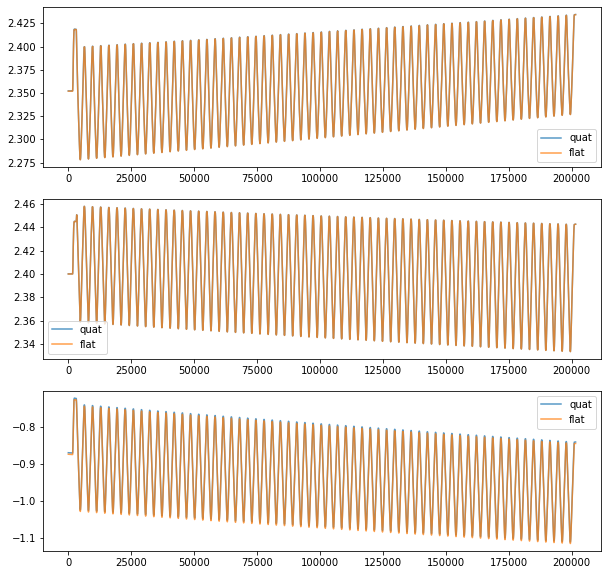

In [5]:
#First make sure the boresight_quats themselves agree with ephem
ra_boresight, dec_boresight, pa_boresight = azel_to_radecpa(times, az , el) 
theta_boresight, phi_boresight, pos_boresight = qa.to_angles(boresight_quat)

fig, axes = plt.subplots(3, figsize=(10,10))

axes[0].plot(phi_boresight, label='quat', alpha=0.75)
axes[0].plot(ra_boresight, label='flat', alpha=0.75)
axes[0].legend()

axes[1].plot(theta_boresight, label='quat', alpha=0.75)
axes[1].plot(dec_boresight, label='flat', alpha=0.75)
axes[1].legend()

axes[2].plot(pos_boresight, label='quat', alpha=0.75)
axes[2].plot(pa_boresight, label='flat', alpha=0.75)
axes[2].legend()

#Close enough?

In [ ]:
#Detector close to boresight
plot_results(det_close)

Reading SQL table pb2a_focalplane...done.
Detector offsets x/y in degrees: -0.06831 -0.008328
Average errors in degrees 0.005960421387528786 0.10673156581793117 0.29452255736880034


In [ ]:
#Detector far from boresight
plot_results(det_far)

In [ ]:
#Try a detector opposite of the far detector
plot_results(det_offset_x= -2.004611, det_offset_y= +1.56563)